## **Notebook PC1_Ativ3**
## Regularized ELM Classifier for the MNIST database.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Arthur Felipe dos Santos Fernandes


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()

X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [2]:
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)

[5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [3]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [4]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_ 

In [5]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function): 
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c): 
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [6]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []
    
    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)
        
        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [7]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the MNIST dataset: 785
# Number of inputs for the CIFAR10 dataset: 3073
# Take 1000 hidden neurons for the MNIST dataset and 2000 for the CIFAR10 dataset.
V  = sigma * np.random.randn(3073, 2000)

In [8]:
c_values = [pow(2,d) for d in range(-16, 14, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


In [9]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


Best c value: 4096 
Performance of this value: 0.4552


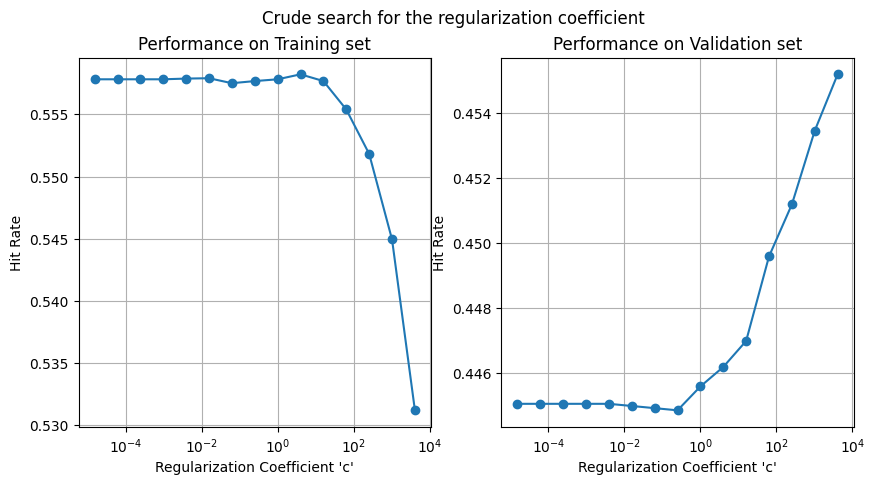

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


In [11]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


In [12]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


Best c value: 4096.0 
Performance of this value: 0.4552


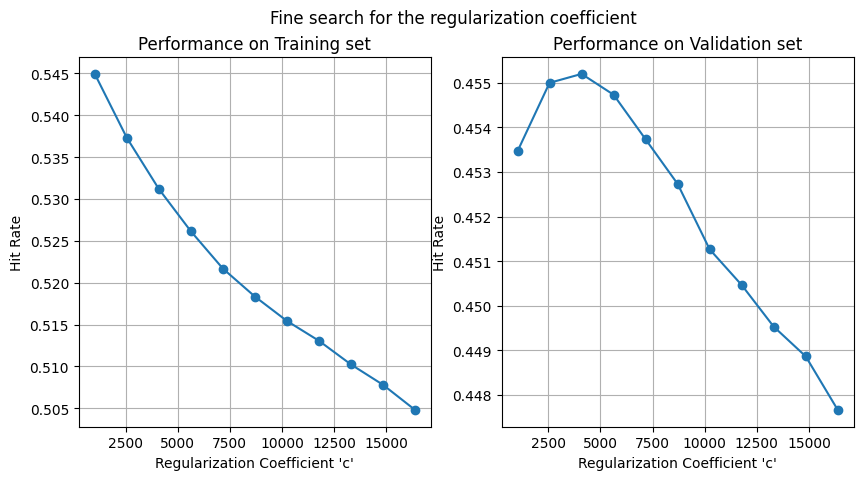

In [13]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [14]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [15]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
print(confusion_matrix)

Performance on test set: 0.4676
[[523  37  97  47  61  35  19  49  98  37]
 [ 50 586  29  59  31  42  33  44  73 191]
 [ 43   9 309  62 140  86  66  42  12   9]
 [  8  19  68 249  38 168  46  59  19  19]
 [ 26  16 113  53 360  57 100  68  12   8]
 [ 14  20  72 178  51 342  49  58  27  22]
 [ 27  26 148 157 145  93 599  48  12  33]
 [ 37  40  86  71  98  91  40 511  19  51]
 [202  77  48  49  49  53  22  38 658  91]
 [ 70 170  30  75  27  33  26  83  70 539]]


Image no. 0


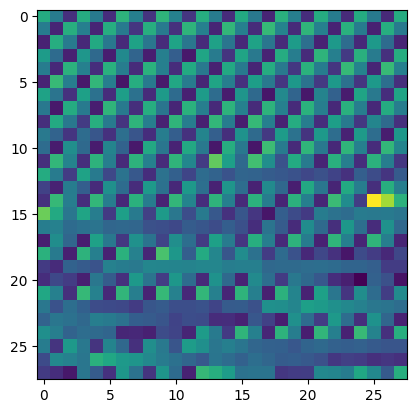

Real: 3
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.10984743  0.34216502  0.15803922  0.30854346  0.03546693  0.1265873
  0.21753826 -0.1439696   0.23483584 -0.10125252] 

Image no. 1


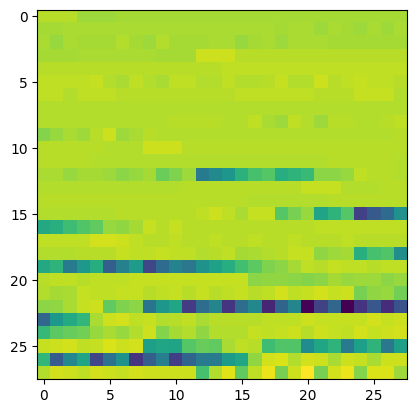

Real: 8
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.12485594  0.21246453  0.0097903  -0.04243207  0.01209831 -0.11173877
  0.06102647 -0.09979664  0.45381603  0.4691916 ] 

Image no. 3


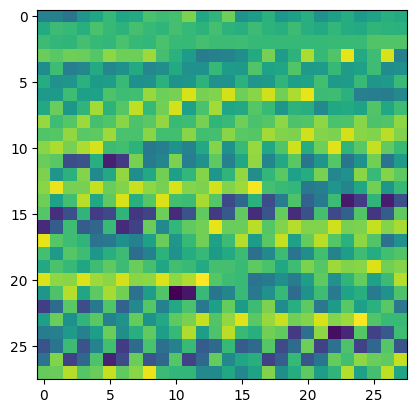

Real: 0
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.24119349  0.09255785  0.15577927  0.03623571  0.19194544 -0.00153365
 -0.05548787  0.05413524  0.32116158  0.01699021] 

Image no. 4


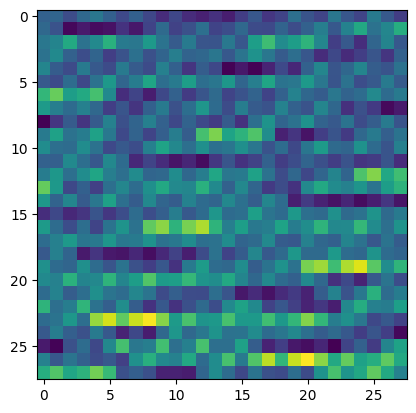

Real: 6
Predicted: 4
Rank of the correct answer: 3
Probabilities: [-0.06972272  0.06553199  0.11660864  0.08930917  0.43834391  0.14006571
  0.11980431  0.09380743  0.09272117 -0.08852395] 

Image no. 8


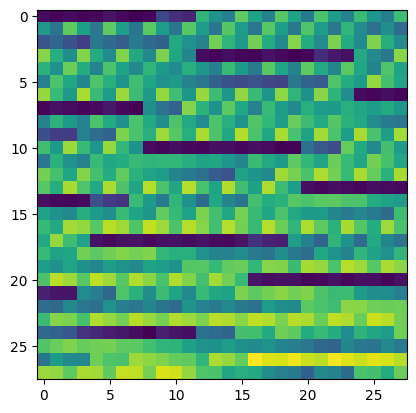

Real: 3
Predicted: 5
Rank of the correct answer: 4
Probabilities: [ 0.0472739   0.08983912  0.16068476  0.14913482  0.17188349  0.26934536
 -0.01140819  0.06459077  0.01090504  0.04675444] 

Image no. 12


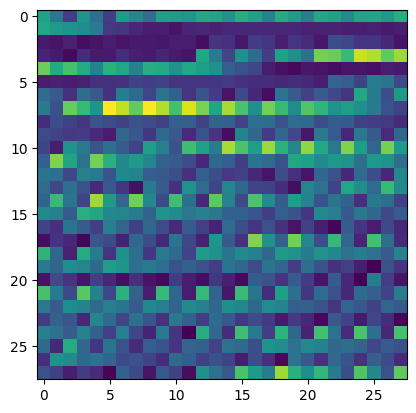

Real: 5
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.11390423  0.35422693  0.07803481  0.04914632  0.00455754  0.21553611
  0.18617514  0.08869302  0.07176458  0.05666226] 

Image no. 14


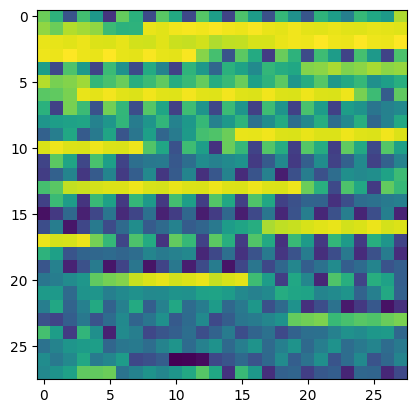

Real: 9
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.19391259  0.33809153  0.0822957   0.04935531 -0.00420839 -0.07145164
  0.06470295  0.14203181  0.27101616  0.33591651] 

Image no. 22


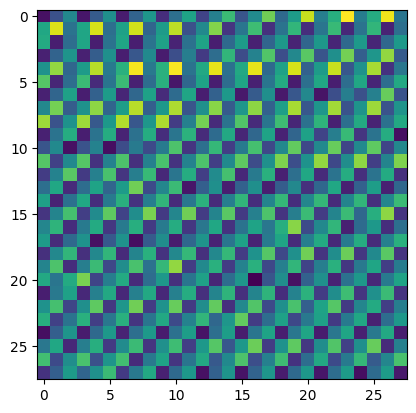

Real: 4
Predicted: 0
Rank of the correct answer: 4
Probabilities: [ 0.44256031  0.04356472  0.17583996  0.00060008  0.09405359 -0.02587064
  0.09861517 -0.01490551  0.08333133 -0.02693026] 

Image no. 23


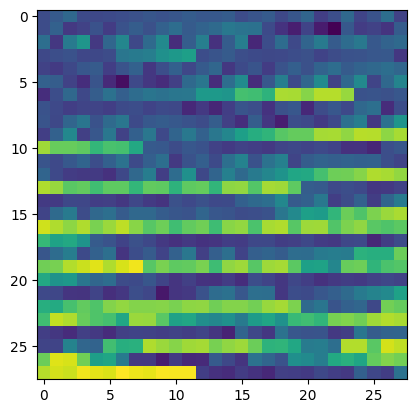

Real: 9
Predicted: 1
Rank of the correct answer: 2
Probabilities: [ 0.173965    0.48123739 -0.10078545 -0.01258262 -0.03081578  0.03749528
  0.15197441 -0.05063257 -0.08815447  0.31694936] 

Image no. 24


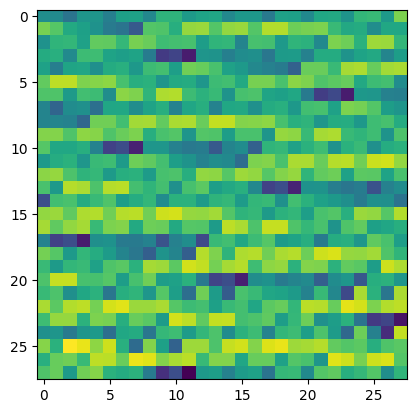

Real: 5
Predicted: 4
Rank of the correct answer: 4
Probabilities: [ 0.09175649  0.03089264  0.19669931  0.00065188  0.34745663  0.12098589
 -0.00849584  0.16572756  0.053014   -0.03722242] 

Image no. 25


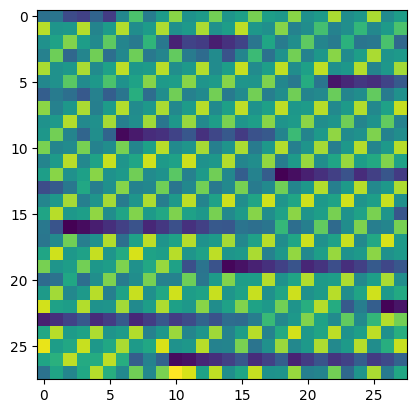

Real: 2
Predicted: 6
Rank of the correct answer: 4
Probabilities: [-0.13873102  0.15617717  0.15332806  0.04650522  0.12967446  0.07307265
  0.30666476 -0.07169845  0.23477748 -0.03399868] 

Image no. 26


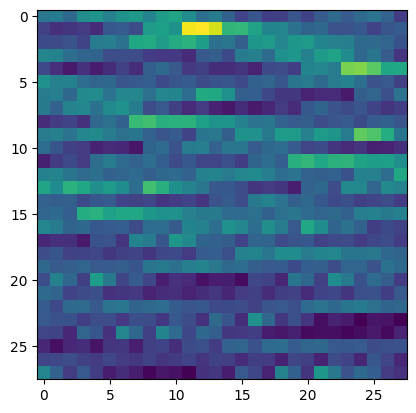

Real: 4
Predicted: 6
Rank of the correct answer: 3
Probabilities: [ 0.15513211  0.09546094  0.20940502  0.15944919  0.18256598  0.08406578
  0.22996529 -0.04812092 -0.12825983  0.09433663] 

Image no. 31


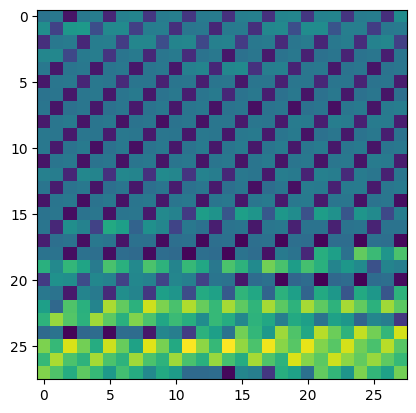

Real: 5
Predicted: 4
Rank of the correct answer: 3
Probabilities: [ 0.09440657 -0.01369601  0.23620351  0.06612955  0.2521487   0.18695074
  0.07760993  0.02655613  0.05635335 -0.03094019] 

Image no. 33


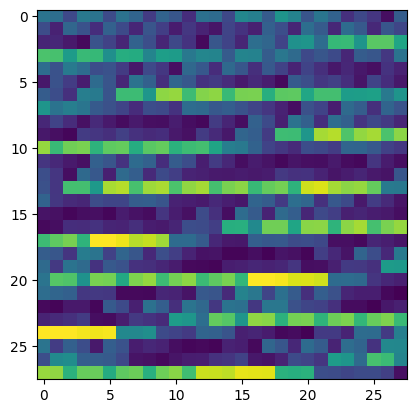

Real: 5
Predicted: 2
Rank of the correct answer: 2
Probabilities: [-0.14421614  0.07992003  0.33875674  0.17954761  0.09958525  0.254536
  0.229845    0.01570271  0.10410095 -0.11052621] 

Image no. 35


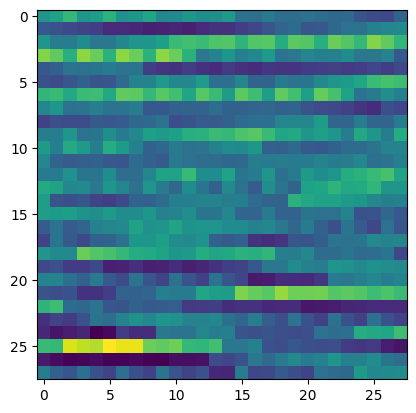

Real: 2
Predicted: 1
Rank of the correct answer: 9
Probabilities: [-0.06677049  0.31325598  0.00231646  0.12729691  0.08489121  0.09498135
  0.10722801  0.16722804  0.04935044  0.12053886] 

Image no. 36


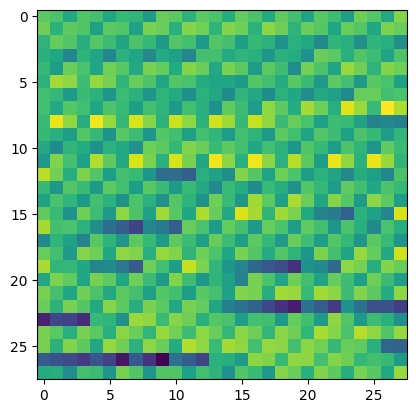

Real: 4
Predicted: 6
Rank of the correct answer: 2
Probabilities: [-0.01546668  0.11556295  0.18191867  0.11809309  0.20501087  0.07179195
  0.24891809  0.0217602   0.02944985  0.0255483 ] 

Image no. 37


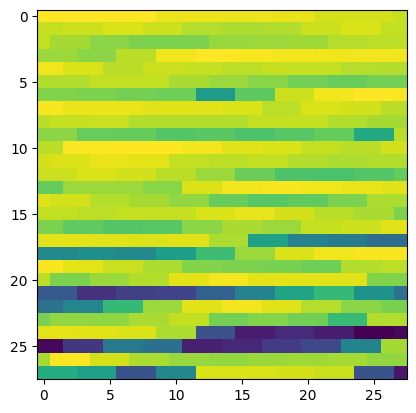

Real: 1
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.02397556  0.3487173  -0.15521567  0.04265608  0.05598425  0.00869634
  0.0435185  -0.03025156  0.30034086  0.47197376] 

Image no. 40


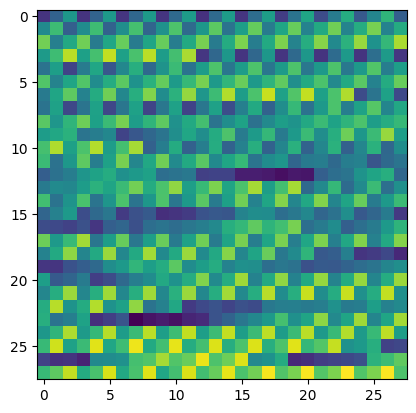

Real: 4
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.31371351  0.06739876 -0.01959646 -0.08597101  0.26040481  0.00264876
 -0.11568756  0.40823016  0.09313428  0.12036364] 

Image no. 42


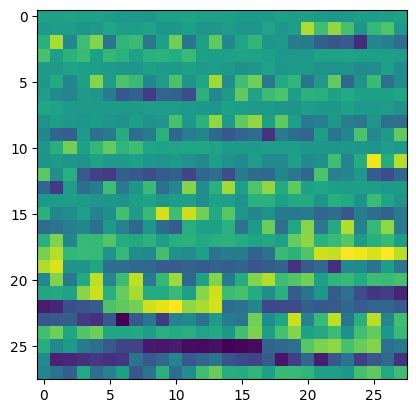

Real: 5
Predicted: 3
Rank of the correct answer: 4
Probabilities: [-0.0402225  -0.02636594  0.0680028   0.3757262  -0.09386487  0.13728903
 -0.03367188  0.20355122  0.06040095  0.30977228] 

Image no. 44


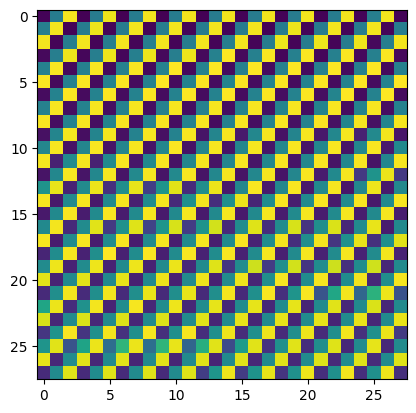

Real: 0
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.27946286  0.02275325 -0.04041143 -0.03066071 -0.09242986 -0.00551132
 -0.14421555  0.36110334  0.25799156  0.33124559] 

Image no. 46


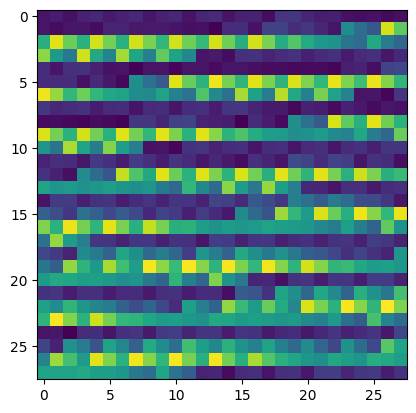

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.10389749  0.01420396  0.10844456  0.30294807  0.03369882  0.32994767
  0.15087925  0.04831193  0.02486703  0.05357782] 

Image no. 47


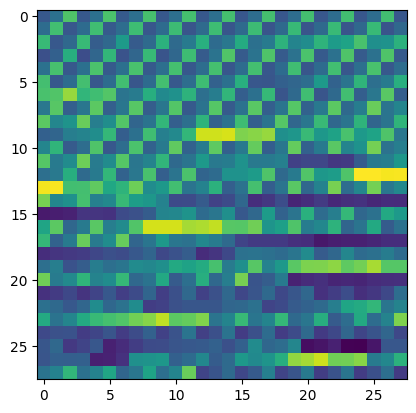

Real: 9
Predicted: 8
Rank of the correct answer: 3
Probabilities: [ 0.10863855 -0.03170919 -0.07743946  0.20024469 -0.00171326  0.02918515
  0.13967948  0.14718075  0.27266241  0.19230145] 

Image no. 48


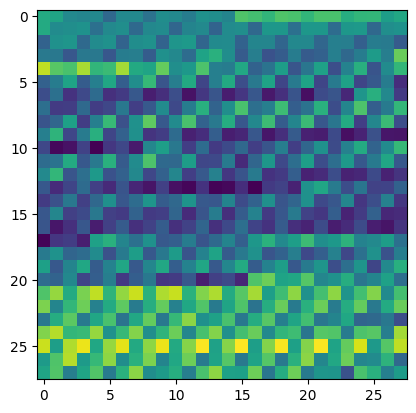

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.03140812 -0.02569725  0.13135066 -0.0324593   0.4004686  -0.00588837
  0.15076905  0.29434466  0.00259071  0.01176075] 

Image no. 52


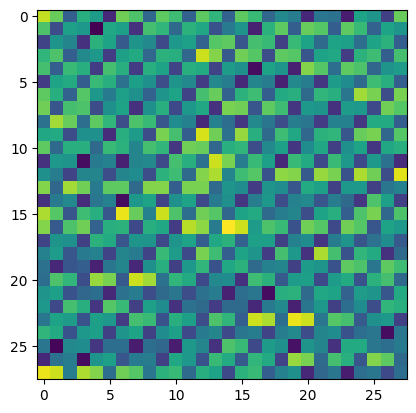

Real: 0
Predicted: 6
Rank of the correct answer: 7
Probabilities: [0.0655539  0.00869854 0.06007922 0.09005448 0.06157672 0.08631883
 0.30402882 0.09529129 0.16388397 0.06690502] 

Image no. 53


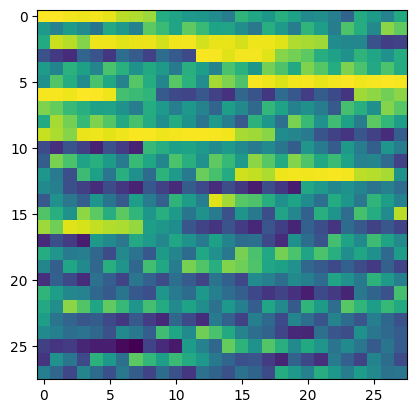

Real: 3
Predicted: 9
Rank of the correct answer: 5
Probabilities: [0.01461976 0.02665543 0.02333026 0.07451429 0.04175001 0.12856916
 0.17064958 0.16933619 0.03326413 0.17493244] 

Image no. 56


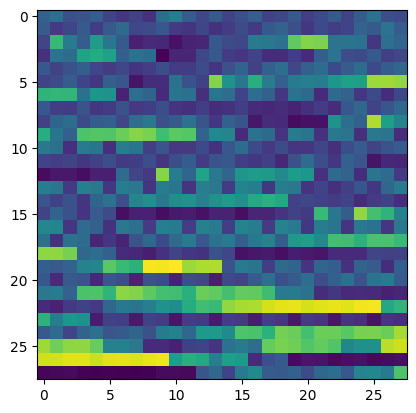

Real: 7
Predicted: 5
Rank of the correct answer: 6
Probabilities: [ 0.14139167 -0.03872242  0.17580434  0.14354309 -0.00274756  0.36794857
  0.21043865  0.13320947 -0.01575644  0.07378159] 

Image no. 57


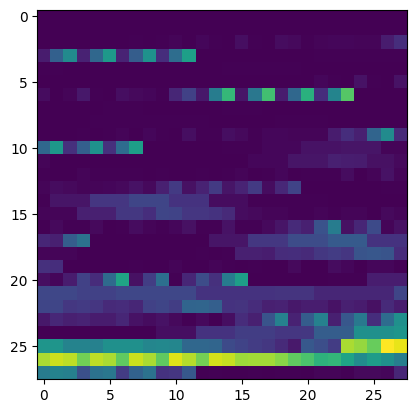

Real: 7
Predicted: 8
Rank of the correct answer: 7
Probabilities: [ 0.02544737  0.13983771  0.06369268  0.10305468 -0.01078268 -0.0441485
  0.23088708  0.0365174   0.33875743  0.12360803] 

Image no. 58


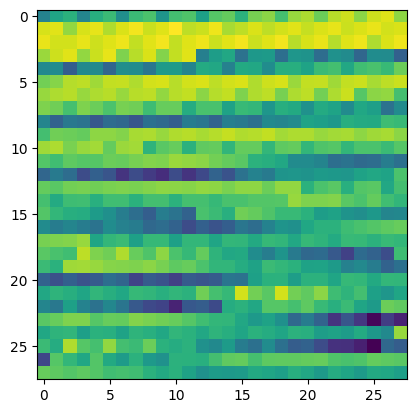

Real: 4
Predicted: 8
Rank of the correct answer: 8
Probabilities: [ 0.04090634 -0.10292103  0.12248272  0.18967627  0.03701342  0.18549907
  0.09981025  0.07690767  0.23898283  0.03253353] 

Image no. 59


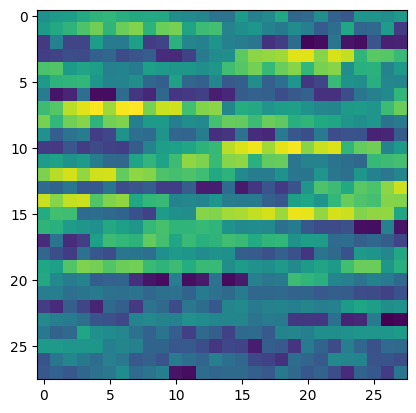

Real: 6
Predicted: 4
Rank of the correct answer: 3
Probabilities: [ 0.11733466 -0.00153002  0.24606182  0.11589484  0.28367942  0.06662906
  0.14803279  0.05003165  0.05985274 -0.02388727] 

Image no. 61


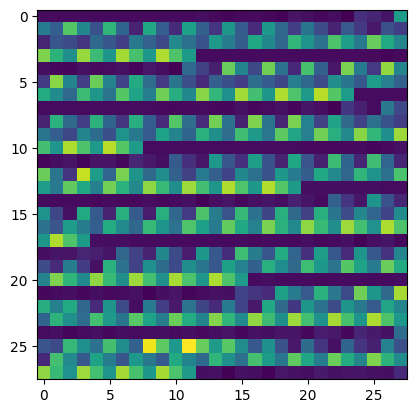

Real: 3
Predicted: 6
Rank of the correct answer: 2
Probabilities: [-0.15790006 -0.12740231 -0.0027401   0.36703855  0.1384585   0.16259404
  0.38313878  0.05841376  0.10618162 -0.00642149] 

Image no. 63


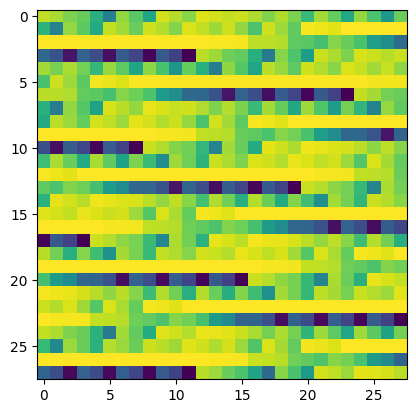

Real: 3
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.06247065  0.09476637  0.06124223  0.11213837  0.0587555   0.18687507
  0.03509998 -0.01202654  0.03019211  0.31407443] 

Image no. 67


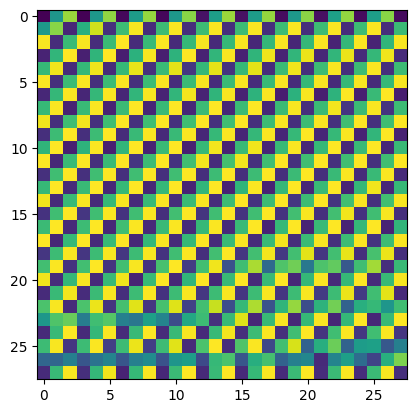

Real: 2
Predicted: 8
Rank of the correct answer: 4
Probabilities: [ 0.33816487 -0.29997247  0.17316523 -0.01568015 -0.01286709  0.13327485
  0.19519866  0.01616756  0.47055266 -0.04111146] 

Image no. 68


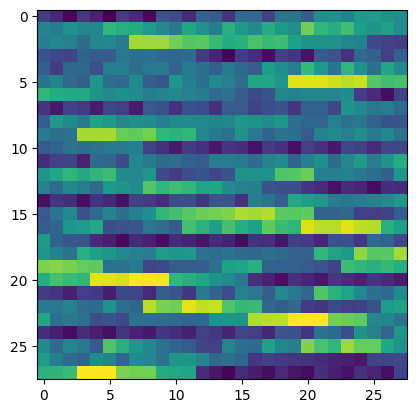

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.07495805  0.02143962  0.17526821  0.23613976 -0.0122932   0.28323543
 -0.00467979  0.1340871   0.02562988  0.13837485] 

Image no. 69


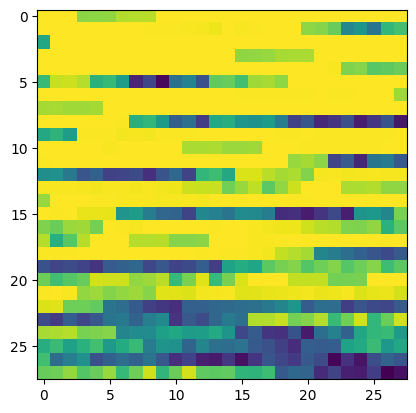

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.05257123  0.26272197  0.00836477 -0.01906027  0.02530461 -0.03290614
 -0.08665397  0.28826112  0.00671703  0.48014695] 

Image no. 71


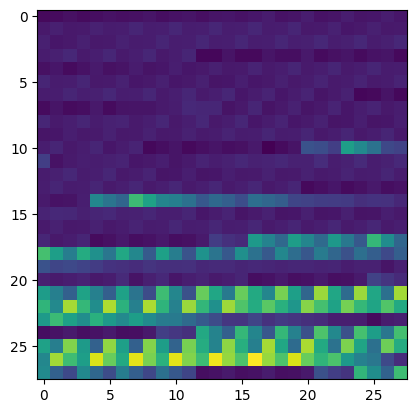

Real: 6
Predicted: 7
Rank of the correct answer: 5
Probabilities: [-0.05424971  0.06642755  0.06407813  0.12776336  0.17772344  0.06879151
  0.12166263  0.26761385 -0.0326727   0.15518729] 

Image no. 78


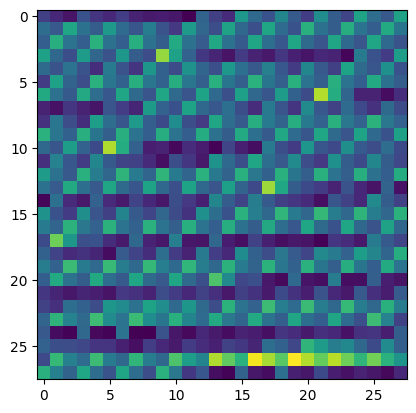

Real: 3
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.01346845  0.01197217  0.09434854  0.2627252  -0.08463666  0.17889662
  0.31391866 -0.02473357  0.01874263  0.10411825] 

Image no. 83


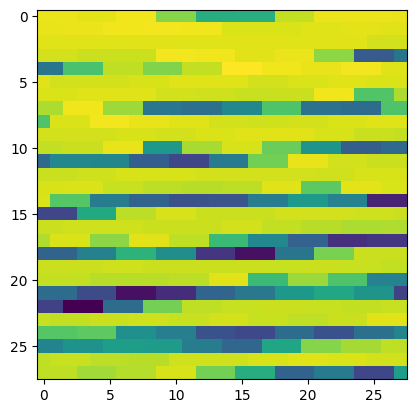

Real: 7
Predicted: 0
Rank of the correct answer: 10
Probabilities: [ 0.27799544  0.02812958  0.22171713  0.18665309  0.05832213  0.05119524
 -0.00599204 -0.04645879  0.15295476  0.11013911] 

Image no. 84


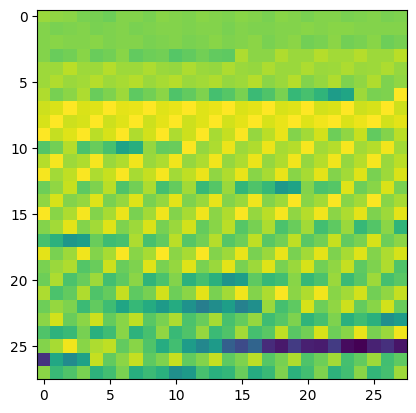

Real: 2
Predicted: 0
Rank of the correct answer: 2
Probabilities: [ 0.29801102 -0.04557535  0.28441788  0.15023847 -0.03336559  0.16054999
 -0.03825334  0.03794713  0.15715807  0.05421644] 

Image no. 85


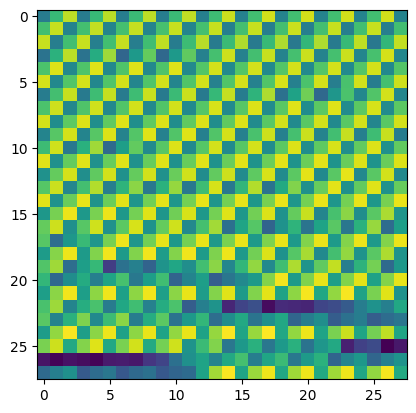

Real: 5
Predicted: 7
Rank of the correct answer: 9
Probabilities: [ 0.13175526 -0.16074976  0.08341775 -0.01199948  0.01211049 -0.04440872
 -0.00790001  0.36654996  0.13736788  0.35255153] 

Image no. 86


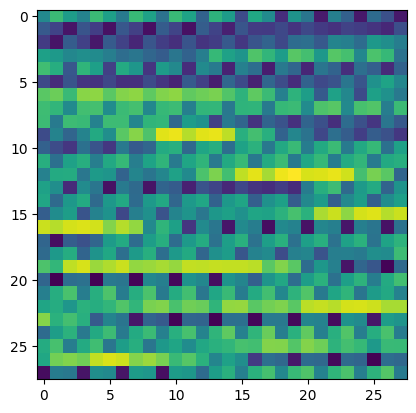

Real: 2
Predicted: 3
Rank of the correct answer: 5
Probabilities: [ 0.24589548 -0.07800133  0.12794975  0.25795393  0.16764437  0.14116744
 -0.0259768   0.09926921  0.03580157 -0.00617087] 

Image no. 87


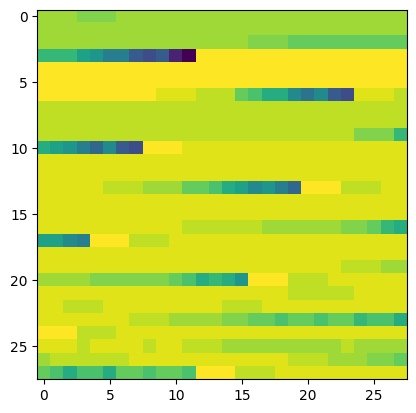

Real: 7
Predicted: 8
Rank of the correct answer: 8
Probabilities: [ 0.22950361  0.04788332  0.08915821  0.01638014  0.04316604  0.02936513
 -0.02780949  0.02490455  0.34579436  0.20063518] 

Image no. 91


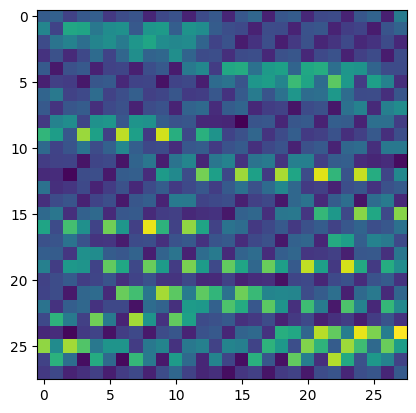

Real: 3
Predicted: 6
Rank of the correct answer: 5
Probabilities: [ 0.00751648 -0.09510923  0.18671831  0.14559684  0.23094195  0.16121285
  0.35086407  0.08136743 -0.06353582  0.00729984] 

Image no. 95


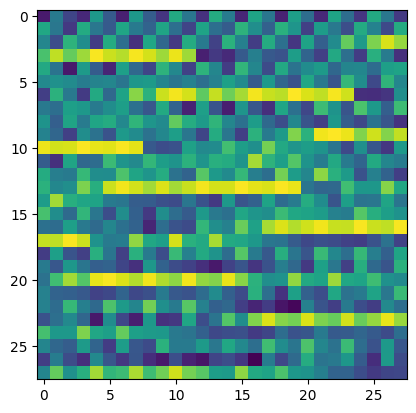

Real: 6
Predicted: 3
Rank of the correct answer: 5
Probabilities: [ 0.06490246 -0.01793122  0.14154563  0.26464727  0.07967616  0.04448807
  0.10226474 -0.01024033  0.13039615  0.20651014] 

Image no. 96


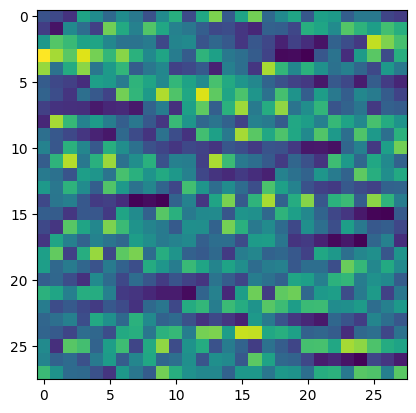

Real: 6
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.05423579  0.08107687  0.1341589   0.11167094  0.23588212  0.15988762
  0.19857941  0.11207476  0.03209714 -0.02075616] 

Image no. 99


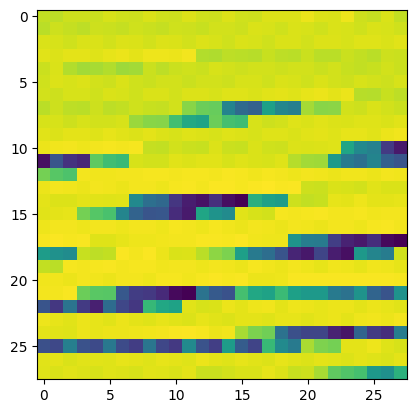

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.16185697 -0.01327308  0.10808111  0.24900659  0.16505334  0.04705938
  0.02299209  0.27175639 -0.1655487   0.31306217] 

Image no. 101


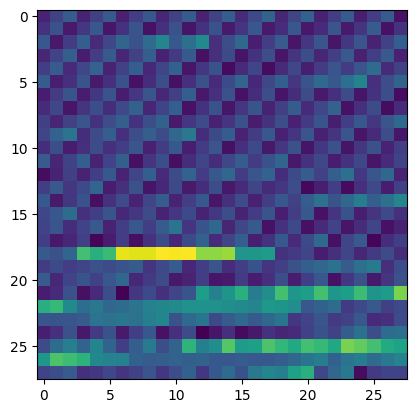

Real: 5
Predicted: 4
Rank of the correct answer: 4
Probabilities: [ 0.0931855   0.1334927   0.03475853  0.06124013  0.25361412  0.12115998
 -0.0048438   0.21037494  0.06673306  0.02528516] 

Image no. 106


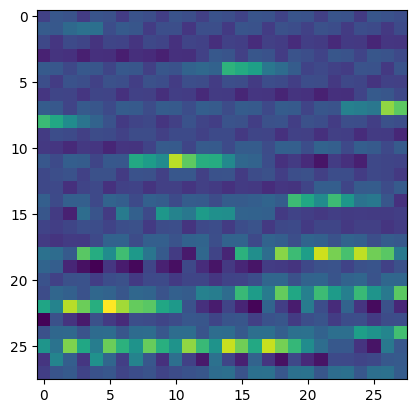

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [ 0.0287156   0.11444946  0.05147348  0.22154311  0.06061697  0.23665277
  0.18630998 -0.0318693   0.12525491 -0.01631071] 

Image no. 109


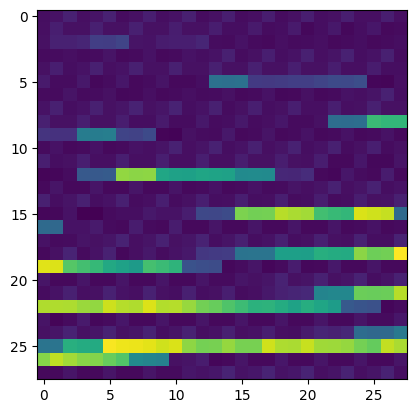

Real: 7
Predicted: 5
Rank of the correct answer: 2
Probabilities: [ 0.04721072 -0.00617766 -0.15383516  0.08998384 -0.03140299  0.35595234
  0.17997859  0.25809984  0.12663093  0.18164588] 

Image no. 110


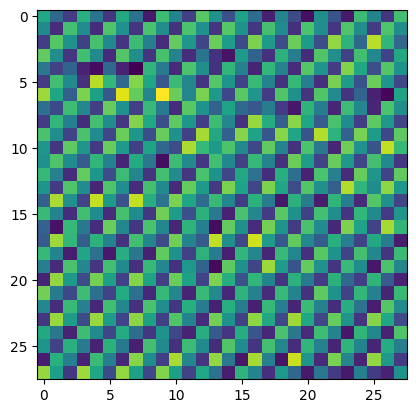

Real: 4
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.08125229  0.0390757   0.03203437  0.08278519  0.27284011  0.13056805
  0.40423003  0.12658122  0.0064608  -0.0589315 ] 

Image no. 111


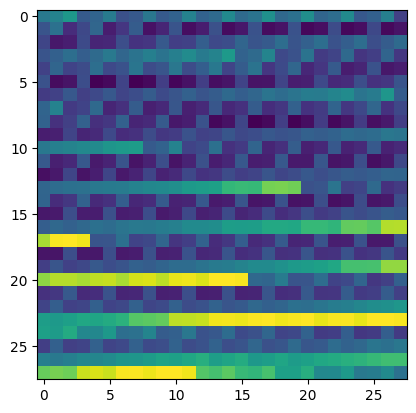

Real: 0
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.24598275  0.07767256  0.28679034  0.16785385  0.16728633  0.15589025
 -0.10249494  0.03937856  0.08786265  0.07114925] 

Image no. 112


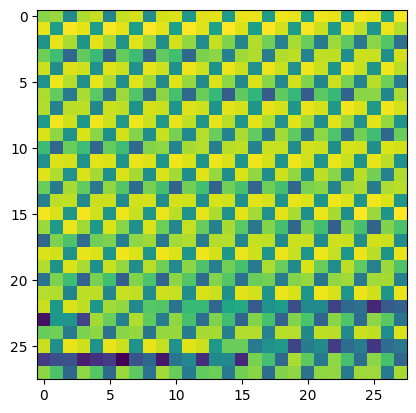

Real: 6
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.12174678 -0.01698152  0.40955422 -0.02765363  0.394793    0.01449234
  0.3793143  -0.16138657 -0.06692611  0.08025599] 

Image no. 113


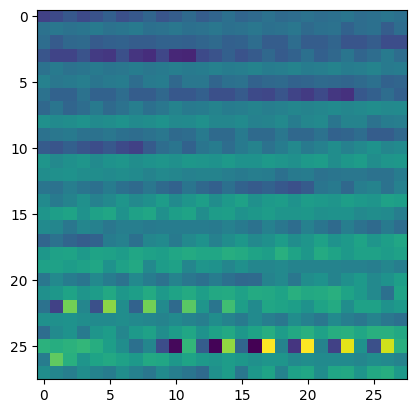

Real: 2
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.03928804 -0.10248447  0.26240306  0.11946777  0.27736917  0.09715376
  0.13218724  0.08944376  0.0779686  -0.09717572] 

Image no. 114


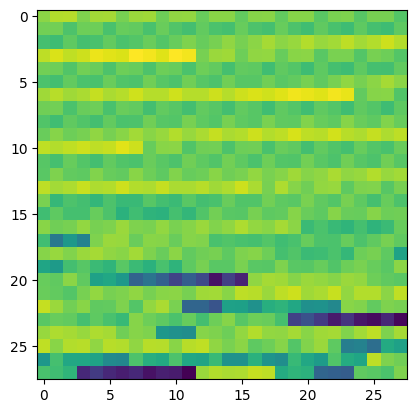

Real: 1
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.08295426  0.2310539  -0.0099821   0.11095114  0.03257456  0.09508374
 -0.05852899  0.1671815   0.06864844  0.27639369] 

Image no. 115


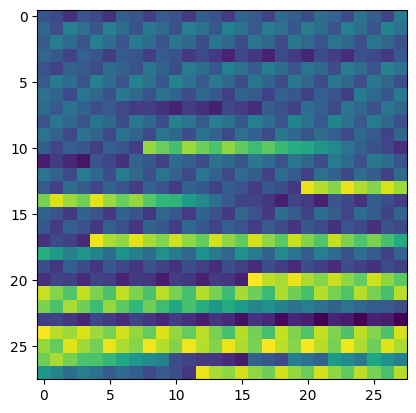

Real: 3
Predicted: 6
Rank of the correct answer: 3
Probabilities: [ 0.00178267  0.14582344  0.05635246  0.19147449  0.1297454   0.19453068
  0.19937323  0.05161617 -0.0053585  -0.01027242] 

Image no. 117


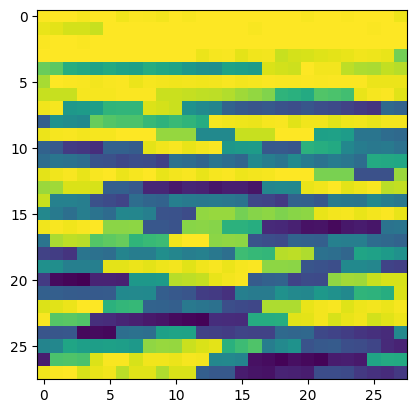

Real: 4
Predicted: 9
Rank of the correct answer: 5
Probabilities: [ 0.04700721  0.05457302  0.16784559 -0.09053804  0.09209799 -0.03326309
  0.01873995  0.18618425  0.12119113  0.37695531] 

Image no. 119


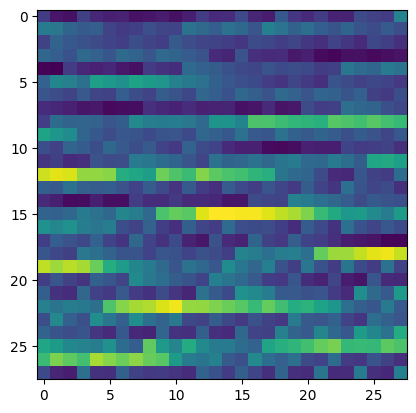

Real: 7
Predicted: 5
Rank of the correct answer: 7
Probabilities: [-0.09584762  0.16106545  0.03344846  0.15486497  0.18392586  0.276413
  0.20034496  0.03658588 -0.03961877  0.22977447] 

Image no. 121


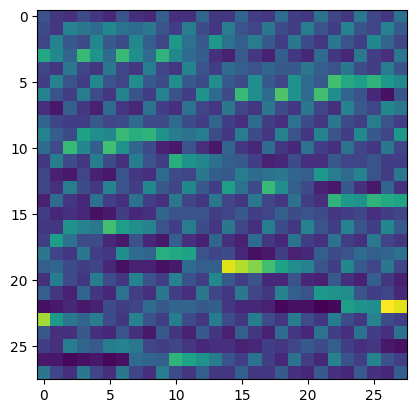

Real: 3
Predicted: 4
Rank of the correct answer: 4
Probabilities: [ 0.01120462 -0.01830212  0.07072953  0.12203714  0.3217465   0.16172378
  0.05388999  0.17768755  0.02906273 -0.02324545] 

Image no. 122


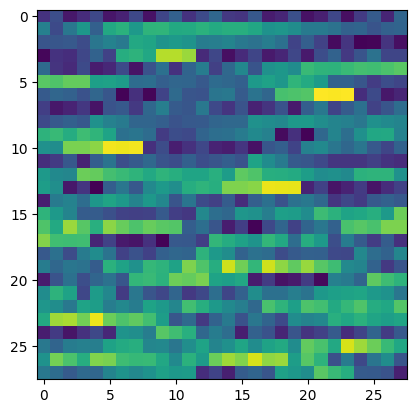

Real: 1
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.04061517  0.15295038  0.06634314 -0.01128446  0.14440332  0.09803082
  0.13734967  0.05534433  0.21012738  0.08746536] 

Image no. 125


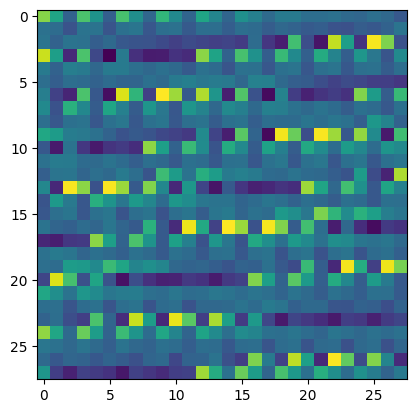

Real: 0
Predicted: 1
Rank of the correct answer: 2
Probabilities: [ 0.207533    0.20874544  0.2007834   0.09362978  0.14897608 -0.13489876
  0.18014538  0.11676737 -0.02053643  0.02788175] 

Image no. 127


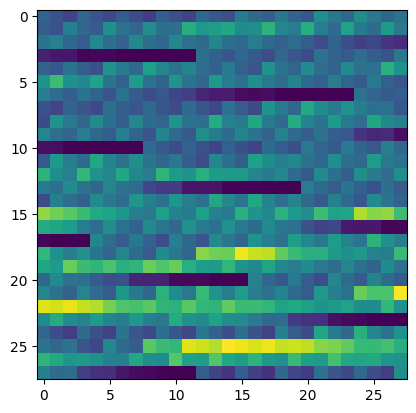

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.04525862  0.05022206 -0.05911825  0.33273956 -0.02444113  0.43110161
 -0.01847564  0.04692599  0.08173267  0.05391465] 

Image no. 128


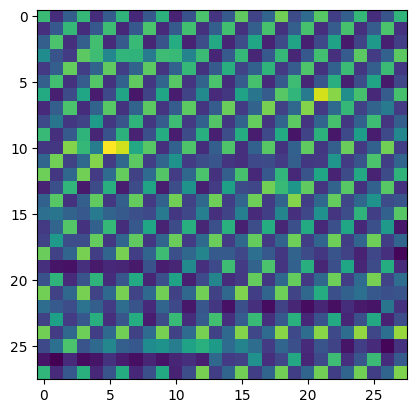

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [ 0.14058007  0.13075397  0.06507298  0.32121485  0.31900644  0.19628108
 -0.03692865  0.05899576  0.02100033 -0.16894147] 

Image no. 129


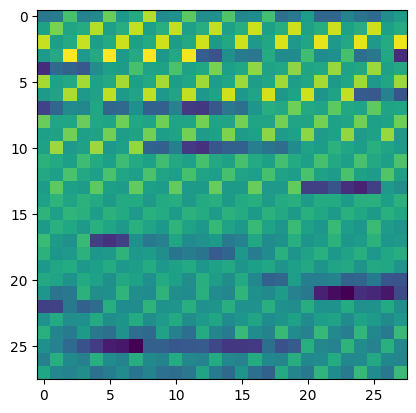

Real: 2
Predicted: 6
Rank of the correct answer: 3
Probabilities: [ 0.21580661  0.01132858  0.11809178  0.10041153  0.09369965  0.10090015
  0.22905445 -0.02065425  0.07782812  0.10559406] 

Image no. 132


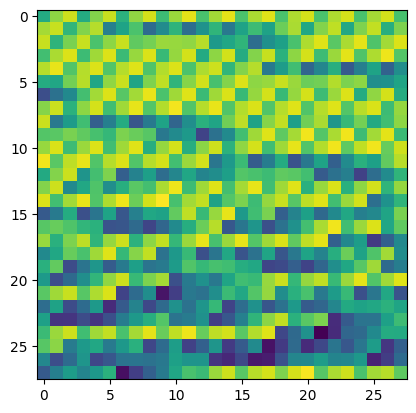

Real: 8
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.11534593  0.23619223 -0.01744252 -0.07513512  0.00193235  0.00472686
  0.06748841  0.0099889   0.22777382  0.3770418 ] 

Image no. 133


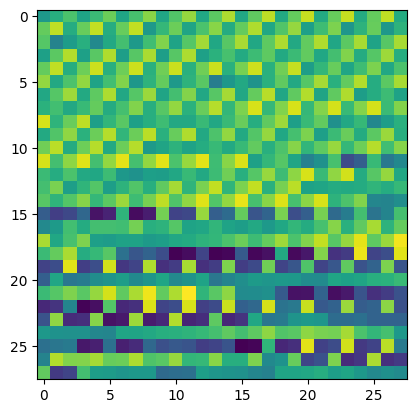

Real: 9
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.29566954  0.12293815 -0.09469444  0.17610957 -0.19583512  0.03854946
 -0.16073728  0.58020587 -0.09947424  0.26097219] 

Image no. 138


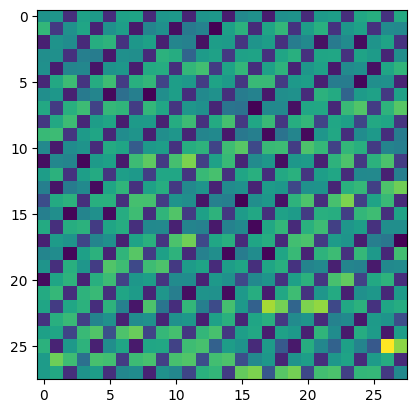

Real: 2
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.04464183 -0.04254066  0.3224686  -0.01083788  0.29622007  0.06516565
  0.43653738 -0.02688695 -0.09701374  0.04174183] 

Image no. 139


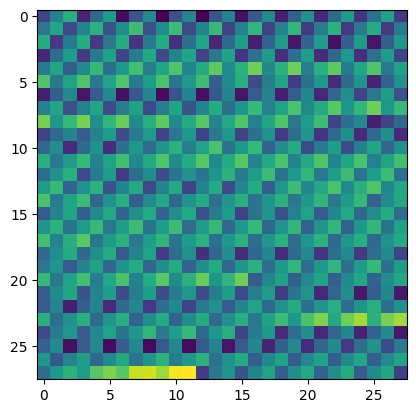

Real: 9
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.10913113  0.13683568  0.07940737  0.00789233 -0.00527318  0.04142645
  0.07797474  0.0070072   0.33611601  0.14532121] 

Image no. 140


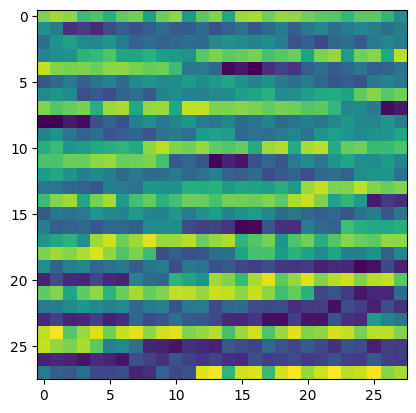

Real: 6
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.05254859  0.09491542  0.22642154  0.04404853  0.20085286 -0.0024595
  0.13358406  0.03298572  0.04942499  0.10277959] 

Image no. 141


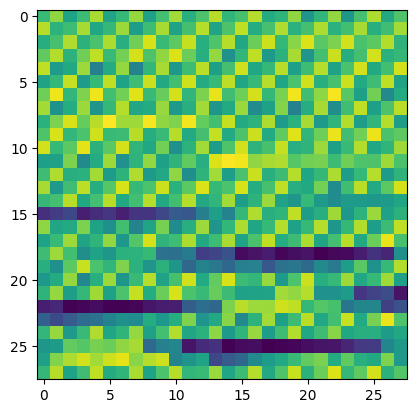

Real: 5
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.01485779  0.20488682  0.14822933  0.02070389 -0.03969013  0.23232988
  0.02703525  0.14992933  0.27912841  0.02829176] 

Image no. 142


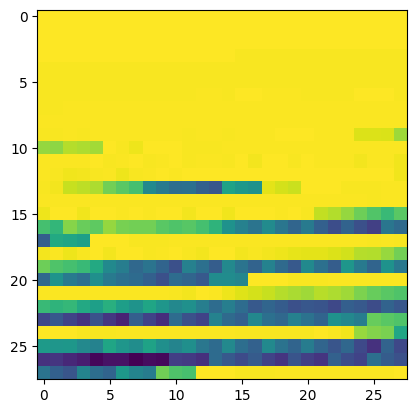

Real: 6
Predicted: 1
Rank of the correct answer: 3
Probabilities: [ 0.17237614  0.24134829  0.04788591  0.10481535  0.0516365   0.07877544
  0.16165508 -0.02156747  0.10210778  0.06974645] 

Image no. 143


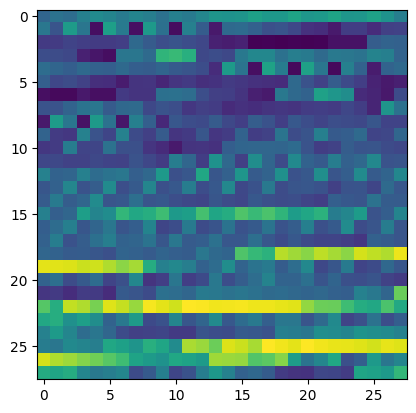

Real: 3
Predicted: 5
Rank of the correct answer: 5
Probabilities: [ 0.05556447  0.24695117  0.01976475  0.06991097  0.03103824  0.29065516
  0.1109479  -0.04813677  0.18003539  0.00362718] 

Image no. 145


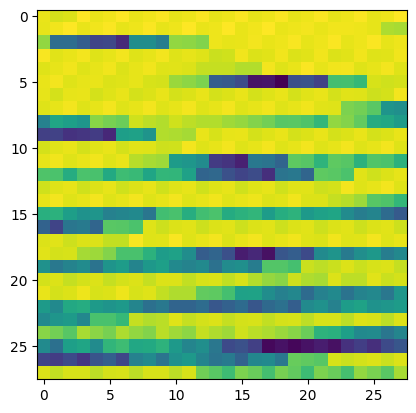

Real: 7
Predicted: 3
Rank of the correct answer: 3
Probabilities: [ 0.15891235 -0.06743667  0.13079758  0.20456711  0.0624556  -0.01023261
  0.06515867  0.18162511  0.18823355  0.06497848] 

Image no. 146


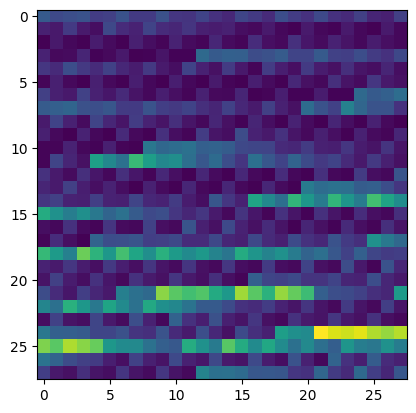

Real: 6
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.06248568  0.01055314  0.11066861  0.12944534  0.10985692  0.07709704
  0.17087727  0.19929856 -0.07252682  0.1310723 ] 

Image no. 147


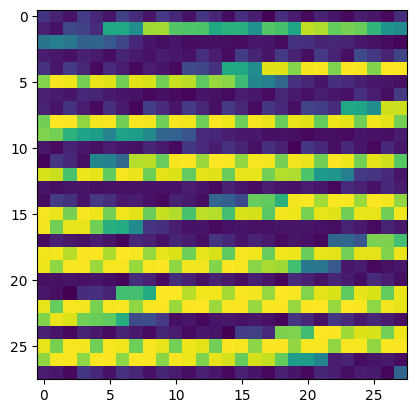

Real: 2
Predicted: 6
Rank of the correct answer: 5
Probabilities: [0.03559171 0.14675544 0.07447603 0.01924677 0.05536775 0.2819562
 0.35774408 0.10771832 0.00583448 0.00862081] 

Image no. 149


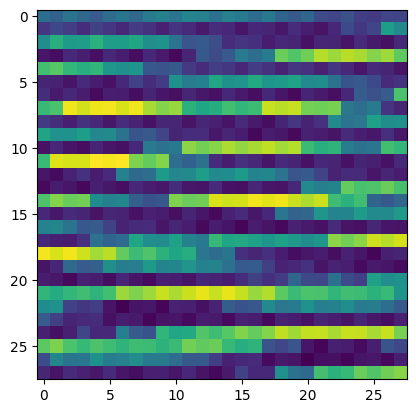

Real: 2
Predicted: 5
Rank of the correct answer: 10
Probabilities: [ 0.07029996  0.0300169  -0.05565728  0.22413789  0.02846672  0.40695076
 -0.00885563  0.04997268  0.05587168  0.16634546] 

Image no. 150


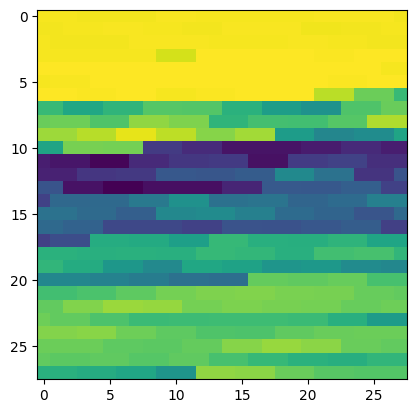

Real: 8
Predicted: 1
Rank of the correct answer: 3
Probabilities: [-0.05195338  0.31904623  0.04020105  0.04435614  0.12266191  0.07558107
  0.11674685  0.09915263  0.12781654  0.2249446 ] 

Image no. 151


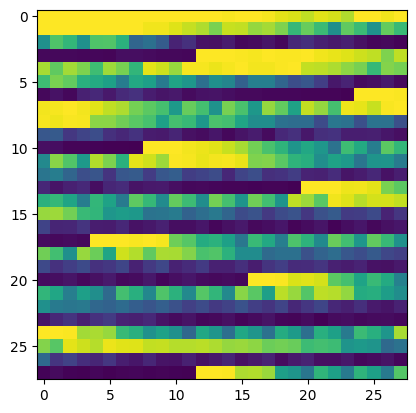

Real: 9
Predicted: 1
Rank of the correct answer: 3
Probabilities: [ 0.00414404  0.32902647 -0.04706656  0.23769793  0.07053471  0.07290149
 -0.0805293   0.13304705  0.04912324  0.16669888] 

Image no. 152


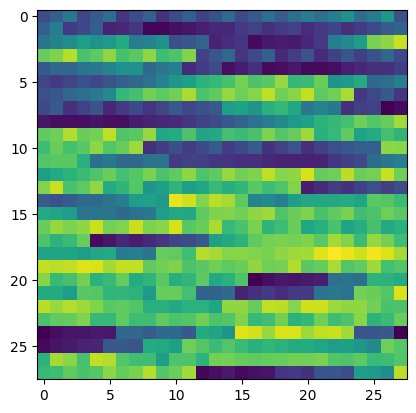

Real: 6
Predicted: 8
Rank of the correct answer: 8
Probabilities: [ 0.0501816   0.07162855  0.10329133  0.03961296 -0.02352218  0.09247839
  0.04664638  0.05873267  0.21698823  0.13463551] 

Image no. 153


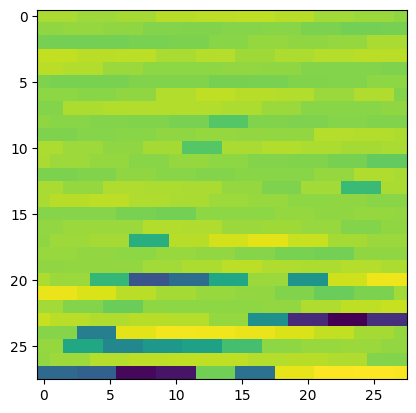

Real: 0
Predicted: 8
Rank of the correct answer: 2
Probabilities: [0.17048404 0.06427426 0.03805178 0.08622063 0.05038853 0.15461676
 0.08930906 0.12140079 0.21797757 0.03379734] 

Image no. 158


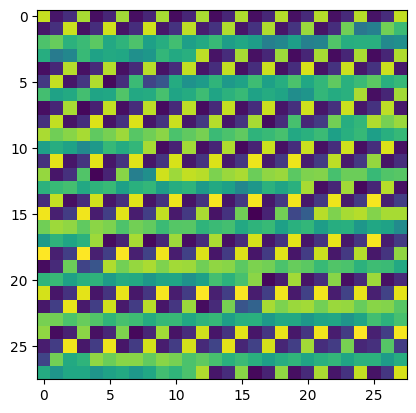

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [-0.0758906  -0.02568487 -0.08125647  0.39790709  0.09313191  0.30028172
  0.3170566   0.09918799 -0.05869067  0.07326305] 

Image no. 159


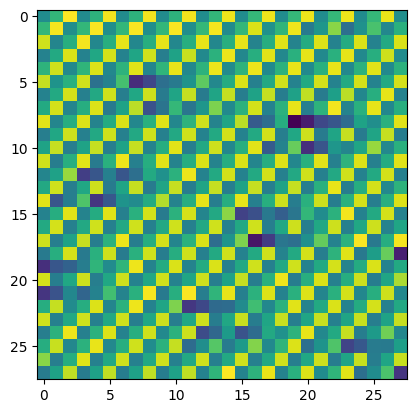

Real: 4
Predicted: 0
Rank of the correct answer: 3
Probabilities: [ 0.28838127  0.00439393  0.05512346  0.00120111  0.17372543 -0.00729246
 -0.05856855  0.20638646  0.11053793  0.12520646] 

Image no. 160


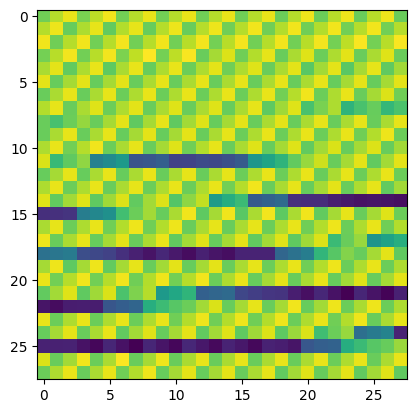

Real: 2
Predicted: 0
Rank of the correct answer: 2
Probabilities: [ 0.38797278 -0.03691238  0.23823192  0.14385727 -0.04986744  0.07100868
  0.0945294  -0.05369265  0.11580514  0.04797723] 

Image no. 162


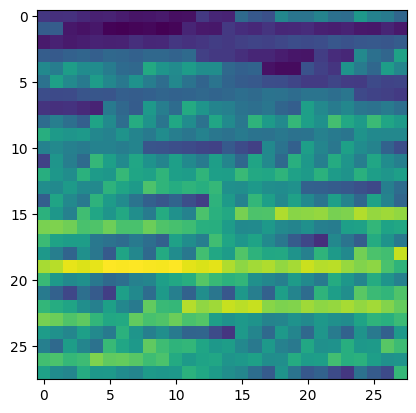

Real: 6
Predicted: 5
Rank of the correct answer: 9
Probabilities: [ 0.0345863   0.24974316  0.10707976  0.24486209  0.08820147  0.27712938
 -0.04938302  0.13038811 -0.18247237  0.0999295 ] 

Image no. 164


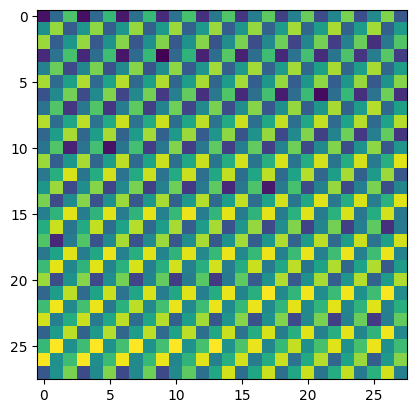

Real: 8
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.11694027 -0.10502316  0.13683362  0.13314018  0.06879304  0.03039916
 -0.00221686  0.11471791  0.23541693  0.31866345] 

Image no. 165


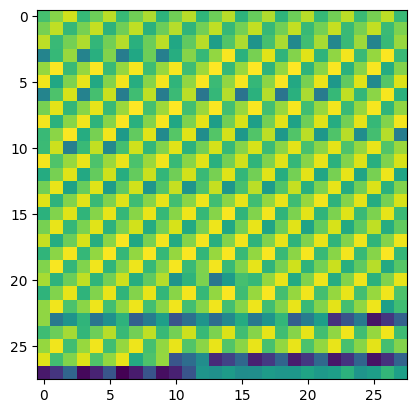

Real: 4
Predicted: 7
Rank of the correct answer: 5
Probabilities: [ 0.24977144 -0.06675679  0.00654708  0.09351185  0.09161881  0.04457868
 -0.05901554  0.37376898 -0.04193924  0.24646107] 

Image no. 167


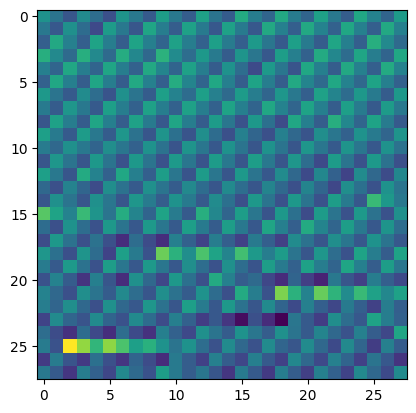

Real: 4
Predicted: 6
Rank of the correct answer: 2
Probabilities: [-0.00436505 -0.04110823  0.17922709  0.10567545  0.22628406  0.09056824
  0.2780816   0.07429079  0.05158788 -0.01657551] 

Image no. 168


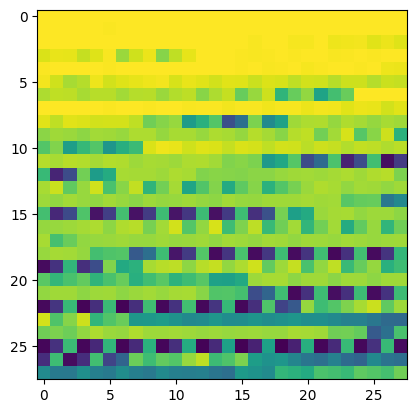

Real: 5
Predicted: 6
Rank of the correct answer: 3
Probabilities: [ 0.14938466 -0.08116172  0.03312688  0.12882994 -0.07042075  0.20644579
  0.29889984  0.29505428 -0.01353826  0.10968372] 

Image no. 169


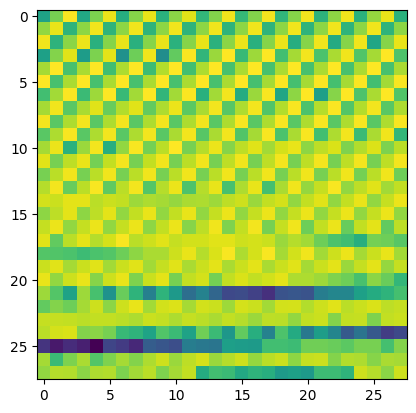

Real: 0
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.1818506  -0.06026945  0.08560007  0.02877286  0.02605623  0.00593916
 -0.02261583  0.22847106  0.15220821  0.37152391] 

Image no. 170


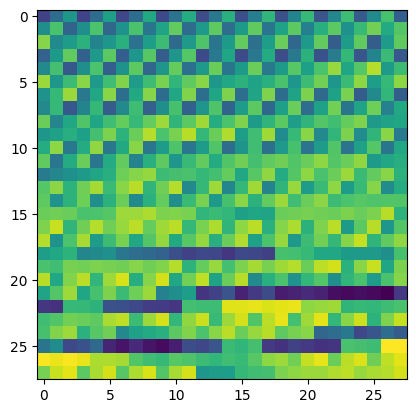

Real: 9
Predicted: 0
Rank of the correct answer: 2
Probabilities: [ 0.28673753  0.10362719  0.02868389  0.1470002   0.04113327  0.1555384
  0.0186772   0.11980895 -0.09759003  0.24084608] 

Image no. 171


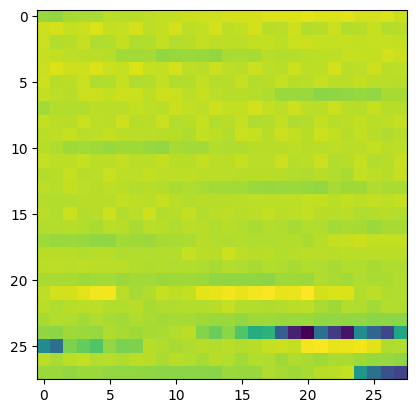

Real: 9
Predicted: 7
Rank of the correct answer: 6
Probabilities: [ 0.21680271 -0.17521109 -0.00387159  0.18253391  0.13536427  0.1331306
  0.05354498  0.27182315  0.02160206  0.05805763] 

Image no. 172


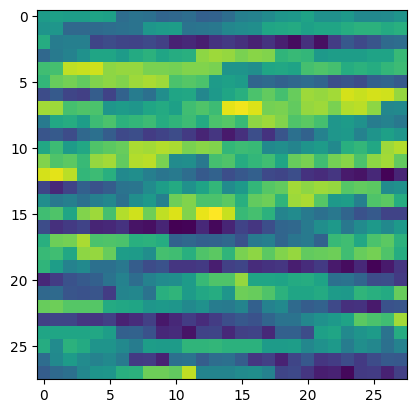

Real: 9
Predicted: 0
Rank of the correct answer: 6
Probabilities: [0.22466356 0.19888619 0.14320726 0.02467481 0.01882432 0.03772276
 0.05656642 0.06420849 0.09290678 0.05872123] 

Image no. 176


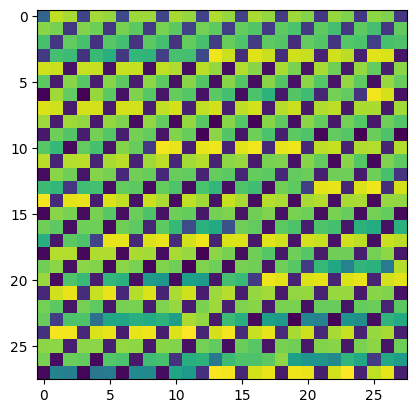

Real: 3
Predicted: 8
Rank of the correct answer: 8
Probabilities: [ 0.32763839  0.09579494  0.13745677 -0.04292269  0.12068136  0.04397855
  0.07775268 -0.08004739  0.39115964 -0.07893444] 

Image no. 177


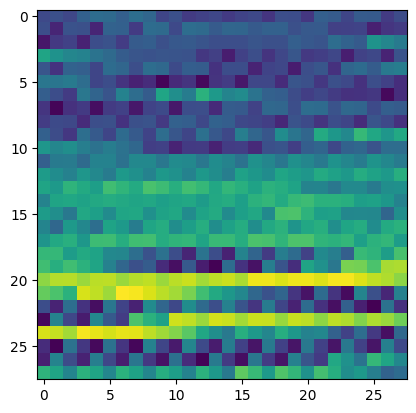

Real: 7
Predicted: 3
Rank of the correct answer: 3
Probabilities: [-0.00957469  0.02640342  0.04766406  0.31158262  0.03253536  0.16602887
  0.2550243   0.25498051 -0.01357563 -0.12324056] 

Image no. 178


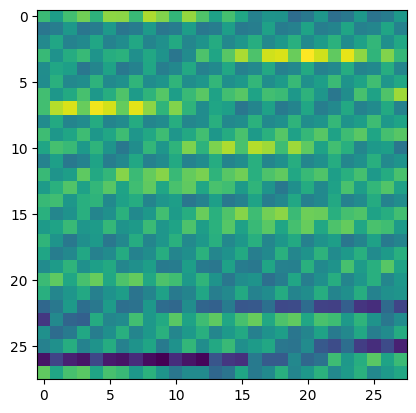

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [0.01843242 0.13502712 0.11955494 0.25785682 0.04695692 0.1249733
 0.04787418 0.02462692 0.04330562 0.05501329] 

Image no. 179


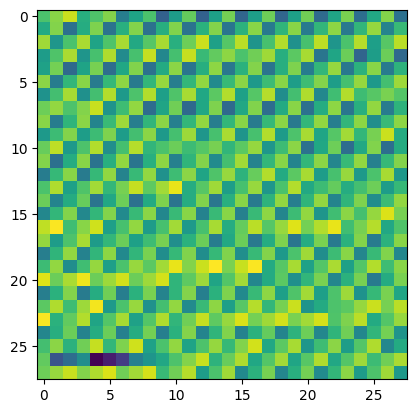

Real: 0
Predicted: 9
Rank of the correct answer: 5
Probabilities: [ 0.11509632  0.08329532  0.12600243 -0.07568518  0.05359674 -0.04517845
 -0.01301959  0.24363798  0.19717739  0.32425463] 

Image no. 180


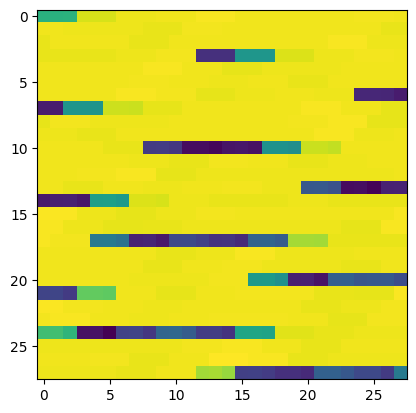

Real: 0
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.2111833   0.21044277  0.04764695  0.07576888 -0.01505523  0.0159584
  0.09387329 -0.12090315  0.11162549  0.38962846] 

Image no. 181


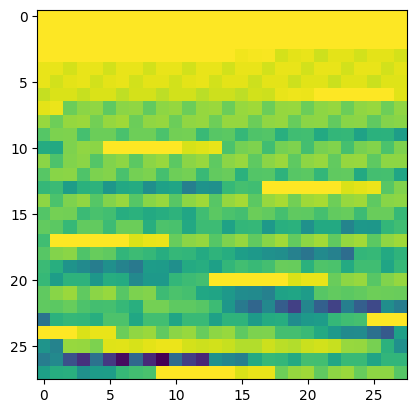

Real: 5
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.04786762 -0.02465688  0.01675217  0.02898181  0.09244351  0.19776924
  0.00776932  0.46203201  0.04144237  0.06477297] 

Image no. 182


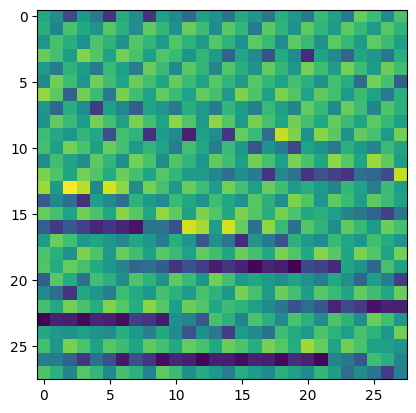

Real: 2
Predicted: 6
Rank of the correct answer: 5
Probabilities: [-0.04448109 -0.14017707  0.10118836  0.12347526  0.14679661  0.21933367
  0.49451573  0.05577407  0.01253146  0.05937435] 

Image no. 184


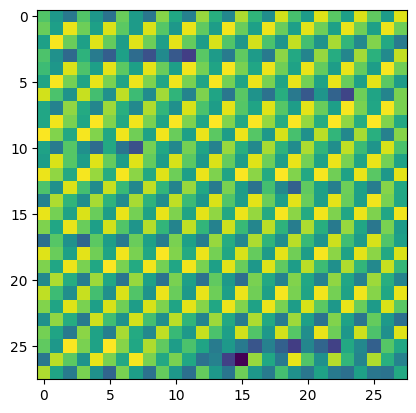

Real: 3
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.10872862  0.03566373  0.14473498  0.15554903  0.1313875   0.16827254
  0.13585729  0.25430269 -0.0364242  -0.07149698] 

Image no. 187


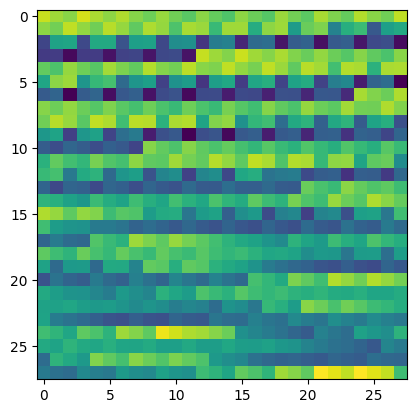

Real: 3
Predicted: 6
Rank of the correct answer: 5
Probabilities: [-0.01120428  0.1034299   0.08447846  0.10021906  0.11045296  0.07669301
  0.15973676  0.06830689  0.11498088  0.09667581] 

Image no. 188


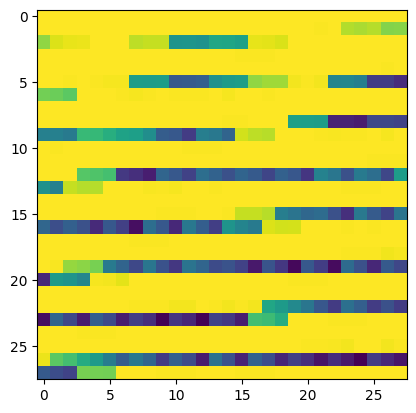

Real: 4
Predicted: 7
Rank of the correct answer: 7
Probabilities: [-0.11727711  0.0926501  -0.06863993  0.24759751 -0.00960675  0.06729821
  0.20133912  0.45707735 -0.03621867  0.14897555] 

Image no. 190


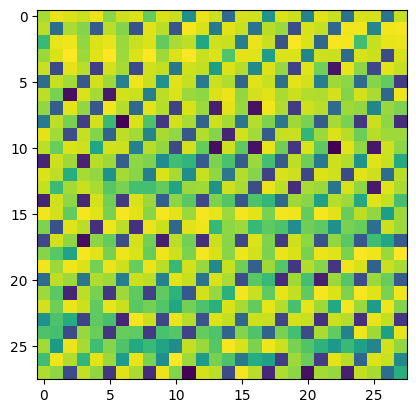

Real: 5
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.10225856  0.07217139  0.20644827  0.06531918  0.20120887  0.225937
  0.32920222 -0.06338986  0.09537549 -0.0935118 ] 

Image no. 191


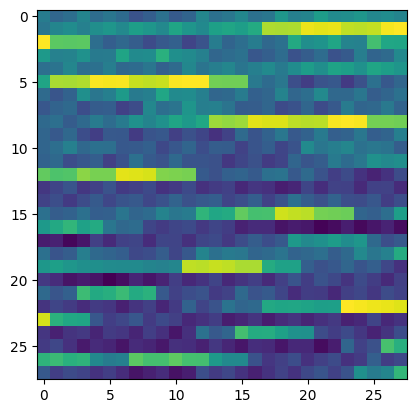

Real: 8
Predicted: 5
Rank of the correct answer: 9
Probabilities: [0.06302742 0.14282678 0.07737729 0.18678232 0.01096648 0.18978722
 0.08857161 0.13843273 0.03751416 0.09889385] 

Image no. 192


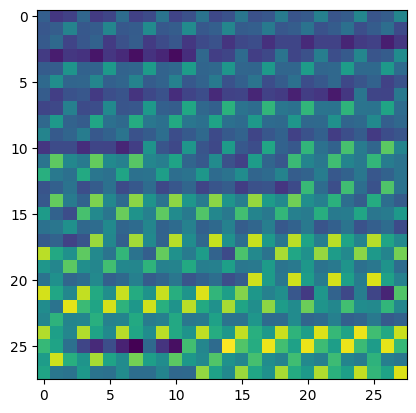

Real: 0
Predicted: 9
Rank of the correct answer: 9
Probabilities: [ 0.03179289  0.10121251  0.1155451   0.13463301  0.06219413  0.16941006
  0.0801771   0.15974956 -0.09804767  0.21196639] 

Image no. 194


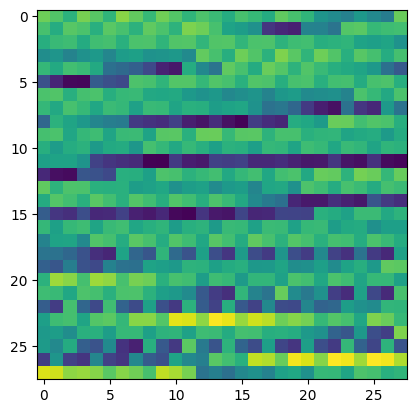

Real: 7
Predicted: 6
Rank of the correct answer: 4
Probabilities: [ 0.01353672  0.03563248  0.18744707  0.1598927   0.08836643  0.02299314
  0.25880608  0.17346525 -0.09542239  0.17881838] 

Image no. 195


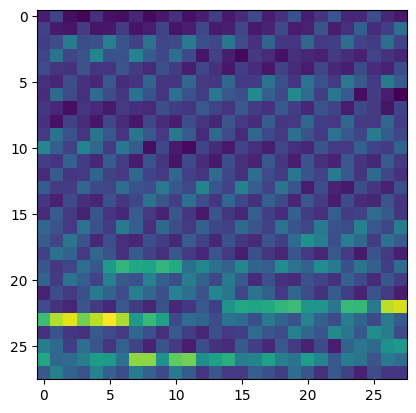

Real: 2
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.12556752  0.13863079  0.17759691  0.06748093  0.21115612  0.09502825
  0.13029131 -0.05290725 -0.01135919  0.01124716] 

Image no. 197


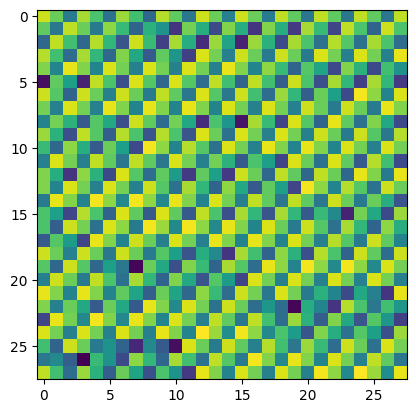

Real: 8
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.22560779 -0.05263834  0.29233237  0.09989211  0.12701008  0.14039395
  0.0462759  -0.04835437  0.24835122 -0.03009364] 

Image no. 199


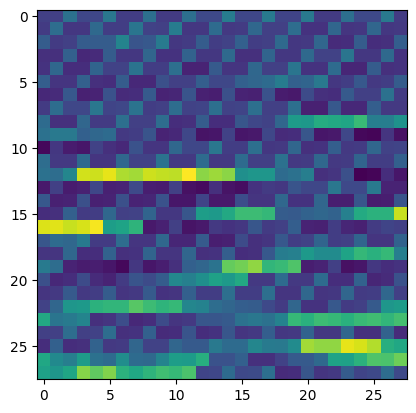

Real: 8
Predicted: 5
Rank of the correct answer: 2
Probabilities: [ 0.18388317 -0.0280634   0.03517845  0.12617907  0.08441795  0.20072672
  0.00210436  0.05589704  0.18553327  0.09222143] 



In [16]:
# Devoted solely to the MNIST dataset
def find_pos(item, lst): 
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z] 
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

1. Não, pois 80% dos casos (houveram 100 testes) determinaram coeficientes de regularização que se encontram na faixa 2^-4 a 2^8.

2. O fato de que a máquina de aprendizado extremo possui 1000 neurônios na camada intermediária, sendo capaz de selecionar aqueles que melhor se adequam à saída desejada e ajustar apenas os pesos da camada de saída

3. Sim, o problema é que a rede não possui flexibilidade o suficiente para resolver o problema de forma satisfatória.